# Hierarchical joins

In [1]:
using ReactiveDynamics

### Environment setup

In [2]:
n_models = 20; r = 2; γ = 2 # number of submodels, resources
rd_models = ReactiveDynamics.ReactionNetwork[] # submodels

ReactiveDynamics.FoldedReactionNetworkType{Symbol, Union{Missing, String, Symbol}, Union{Float64, Int64, AbstractString, Expr, Function, Symbol}, Set{Symbol}, ReactiveDynamics.FoldedObservable}[]

In [3]:
@register begin
    ns = Int[] # submodel size
    rd_models = ReactionNetwork[] # submodels
    ns = Int[] # size of submodels
    M = Array[] # transition intensities of submodels
    cycle_times = Array[] # cycle times of transitions in submodels
    demand = Array[]; production = Array[]; # resource production / generation for transitions in submodels
end

Array[]

### Submodels: dense interactions

In [4]:
@generate {@fileval(submodel.jl, i=$i, r=r), i=1:n_models};

### Batch join over the submodels

In [5]:
rd_model = @generate "@join {rd_models[\$i], i=1:n_models, dlm=' '}"; # switched to string-GenEx to enable ' ' separator

In [6]:
@generate {@equalize(rd_model, @alias(resource[$j])={rd_models[$i].resource[$j], i=1:n_models, dlm=:(=)}), j=1:r}; # identify respective resource species

### Sparse off-diagonal interactions

In [7]:
sparse_off_diagonal = zeros(sum(ReactiveDynamics.ns), sum(ReactiveDynamics.ns))
for i in 1:n_models
    j = rand(setdiff(1:n_models, (i, )))
    i_ix = rand(1:ReactiveDynamics.ns[i]); j_ix = rand(1:ReactiveDynamics.ns[j])
    sparse_off_diagonal[i_ix+sum(ReactiveDynamics.ns[1:i-1]), j_ix+sum(ReactiveDynamics.ns[1:j-1])] += 1
    interaction_ex = """@push rd_model begin 1., var"rd_models[$i].state[$i_ix]" --> var"rd_models[$j]__state[$j_ix]" end"""
    eval(Meta.parseall(interaction_ex))
end

sparse_off_diagonal += cat(ReactiveDynamics.M...; dims=(1,2));

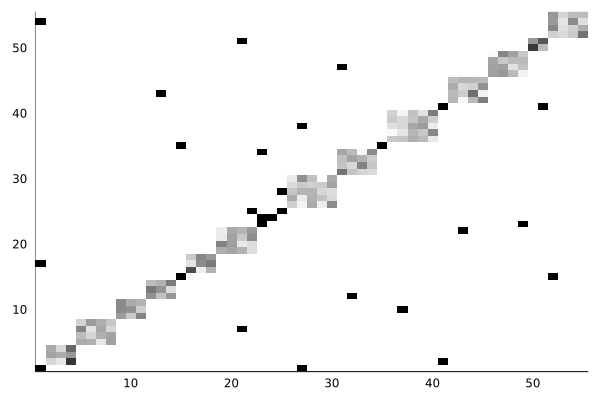

In [8]:
using Plots; heatmap(1 .- sparse_off_diagonal, color = :greys, legend=false)

### Problematize the model

In [11]:
using ReactiveDynamics: nparts
u0 = rand(1:1000, nparts(rd_model, :S))
@prob_init rd_model u0

@prob_meta rd_model tspan=100

prob = @problematize rd_model;

### Solve the problem

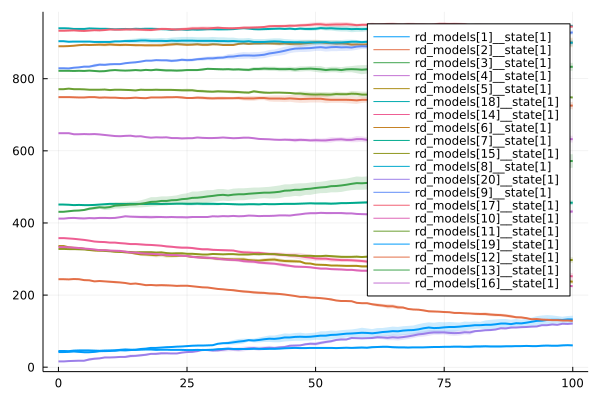

In [12]:
sol = @solve prob trajectories=5

# plot "state" species only
@plot sol plot_type=summary show=r"state\[1\]"